# DESIGNING CONTROLLERS

This notebook summarizes modeling with Antimony and constructing a PID controller.

# Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
try:
    import tellurium as te
except:
    !pip install -q tellurium
    import tellurium as te
from typing import List, Optional

# Helpers

In [2]:
TEST_MODEL = """
S1 -> S2; S1
S2 -> S3; S2
S1 = 10
S2 = 0
S3 = 0
ref := 10
"""

## plotRow

In [3]:
def plotRow(models: List[str], titles: List[str],
        num_column:int=4,
        start_time:float=0.0,
        end_time:float=30.0,
        reference_name:str="ref",
        output_name:str="S3",
        ymax:float=10.0,
        is_plot=True):
    """
    Plots a row of models in sequence

    Args:
       models: list of model strings
       titles: list of titles for the plots
       num_column: number of columns in the row of plots
       start_time: start time for simulation
       end_time: end time for the simulation
       reference_name: name of the reference
       output_name: name of the measured output
       ymax: maximum value on the y axis
    """
    num_point = int(10*(end_time - start_time))
    _, axes = plt.subplots(1, num_column, figsize=(15, 5))
    for idx, model in enumerate(models):
        # Do the simulation
        rr = te.loada(model)
        is_ref = reference_name in rr.keys()
        selections = ["time", output_name]
        if is_ref:
            selections.append(reference_name)
        data = rr.simulate(start_time, end_time, num_point, selections=selections)
        # Construct the plot
        ax = axes[idx]
        ax.plot(data["time"], data[output_name], color="blue")
        if is_ref:
            ax.plot(data["time"], data[reference_name], linestyle="--", color="red")
            ax.legend([output_name, reference_name])
        else:
            ax.set_ylabel(output_name)
        ax.set_title(titles[idx])
        ax.set_xlabel("time")
        ax.set_ylim([0, ymax])
    for idx in range(len(models), num_column):
        axes[idx].axis("off")
    if not is_plot:
        plt.close()

# Tests
is_plot = False
plotRow([TEST_MODEL, TEST_MODEL], ["one", "two"], reference_name=None, is_plot=is_plot)
plotRow([TEST_MODEL, TEST_MODEL], ["one", "two"], is_plot=is_plot)
print("OK!")

OK!


# Antimony and Tellurium Basics

Antimony is a language for modeling chemical systems that allows the modeller to describe how species are transformed into other species by reactions.

A reaction has:
* a left hand side that specifies reactants
* a right hand side that specifies products
* a rate law that is a mathematical expression of the rate (flux) of the reaction

For example:

    J1: A + B -> C + D; k*A*B
    
    k = 2

``J1`` is the name of a reaction that transforms species ``A`` and ``B`` into ``C`` and ``D`` at a rate that is k times the current concentration of ``A`` and ``B``.

# Sequential Pathway (Open Loop)

We are given a sequential pathway that is fed by the boundary species $S_1$. The input $S_1$ is corrupted by a sinusoidal disturbance at time 10. How to do regulate the pathway to ensure that the output is 5?

$S_1 \xrightarrow{k_1 S_1} S_2 \xrightarrow{k_2 S_2} S_3 \xrightarrow{k_3 S_3} \emptyset,~~ k_1 = 1, k_2 =2, k_3=0.5$

In [4]:
DELTA = 3

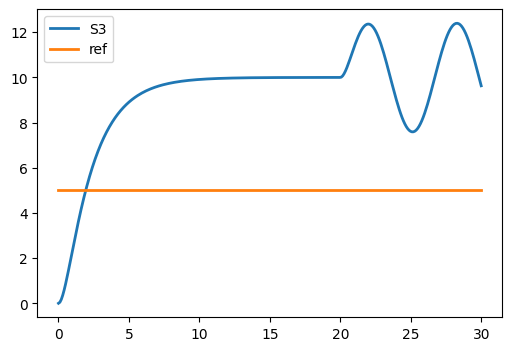

In [5]:
SEQUENTIAL_MODEL = f"""
S1 -> S2; k1*(S1 + delta*sin(time))
S2 -> S3; k2*S2
S3 -> ; k3*S3
k1 = 1
k2 = 2
k3 = 0.5
ref = 5
delta = 0
$S1 = 5
at time>20: delta = {DELTA};
"""
rr = te.loada(SEQUENTIAL_MODEL)
rr.simulate(0, 30, 300, selections=["time", "S3", "ref"]) # Simulate the interval [0, 30] with 300 points
rr.plot()

**System description and control objectives**
1. What is the open loop system?
1. What is the output (measured output) you want to control?
1. Requirements for effective control.
    1. How accurately must the controller track the objective (bias)?
    1. How quickly must the controller adjust after a disruption (settling time)?
    1. Tolerance of oscillations, overshoot, undershoot?

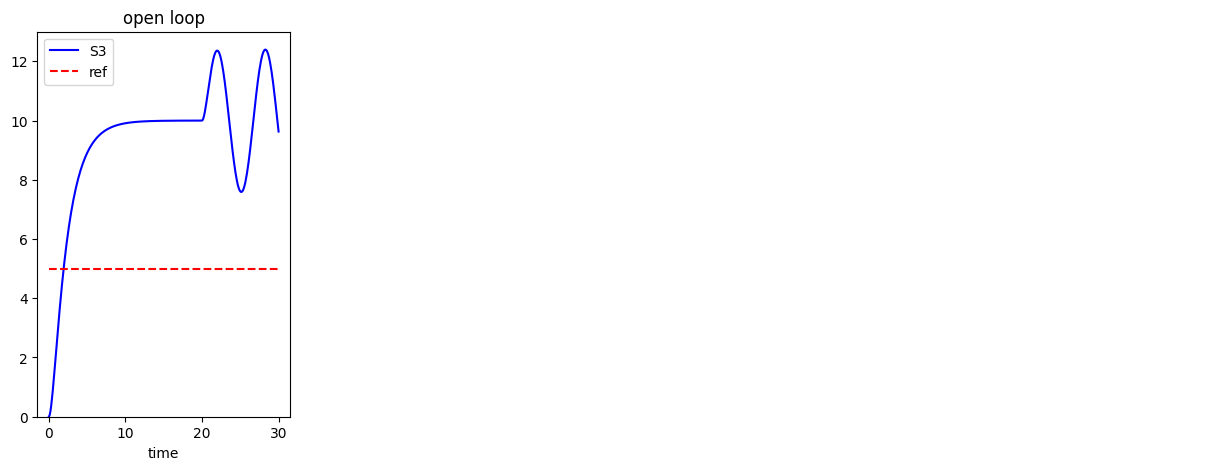

In [6]:
plotRow([SEQUENTIAL_MODEL], ["open loop"], ymax=13)

**Observations**
1. Very limited ability to control the output.

1. Antimony model
2. Tellurium with plots
3. Regulating the output

# Proportional (P) Controller

<img src="https://raw.githubusercontent.com/joseph-hellerstein/advanced-controls-lectures/main/short_class_lectures/images/simple_feedback.png" 
         alt="Types of feature extractiom."
         width="600">

We insert an external controller that regulates $u(t) = S_1$ instead of maintaining it at a fixed value. The instantaneous value of $S_1$ is calculated from the control error, $e(t)$: $$S_1 (t) = k_P e(t)$$

The design problem is to select thee appropriate value of $k_P$, the constant for the proportional controller.

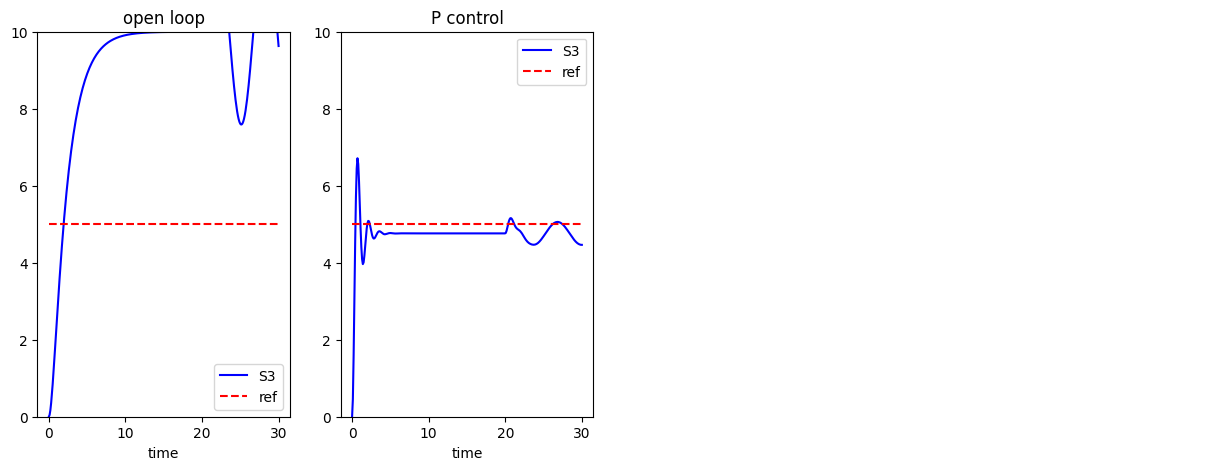

In [7]:
PCONTROL_MODEL = f"""
const S1;

S1 -> S2; k1*(S1 + delta*sin(time))
S2 -> S3; k2*S2
S3 -> ; k3*S3
k1 = 1
k2 = 2
k3 = 0.5
ref = 5
delta = 0
$S1 = 5
at time>20: delta = {DELTA}

// Proportional controller
kP = 10;
control_error := ref - S3
S1 := kP*control_error
"""
plotRow([SEQUENTIAL_MODEL, PCONTROL_MODEL], ["open loop", "P control"])

Plot reference and output

**Observations about Proportional Control**
* Appeal
    1. Can automatically find the right input to match the output.
    2. Can adjust to random fluctuations
* Issues
    1. Does not achieve reference (**bias**)
    2. Lower bias with larger gain ($k_P$), but also get (**overshoot** and **oscillations**)

# Proportional Integral (PI) Controller

We change to an propportional integral (PI) controller to take into account more history.

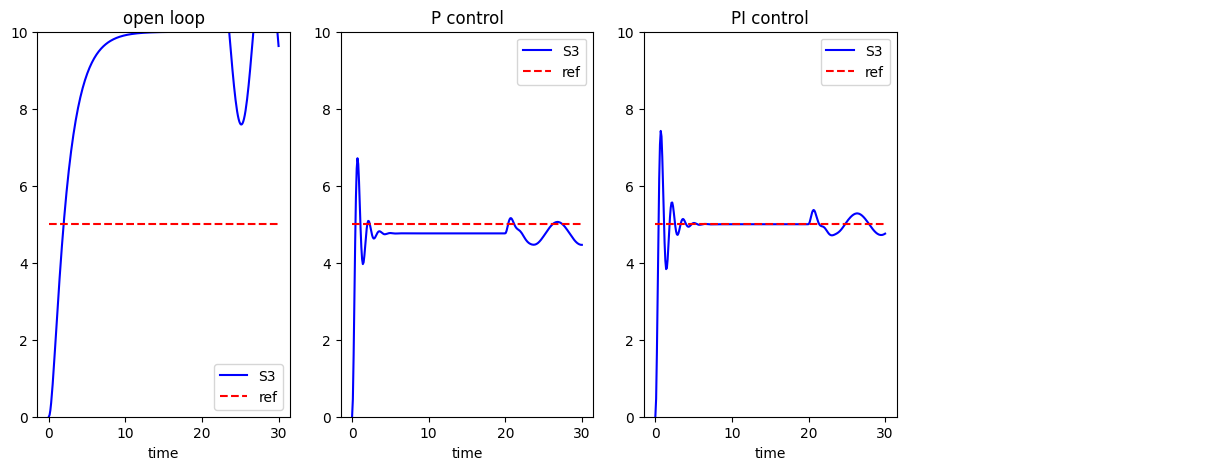

In [8]:
PICONTROL_MODEL = f"""
const S1;

S1 -> S2; k1*(S1 + delta*sin(time))
S2 -> S3; k2*S2
S3 -> ; k3*S3
k1 = 1
k2 = 2
k3 = 0.5
ref = 5
delta = 0
$S1 = 5
at time>20: delta = {DELTA};

// Proportional controller
kP = 10;
kI = 5
control_error := ref - S3
integral_error = 0
integral_error' = control_error
S1 := kP*control_error + kI*integral_error
"""
plotRow([SEQUENTIAL_MODEL, PCONTROL_MODEL, PICONTROL_MODEL], ["open loop", "P control", "PI control"])

**Observations on PI Controller**
* Pro
    1. Eliminates bias
* Con
    1. Complicated to set $k_P$, $k_I$ since two parameters
    2. Can go unstable in unexpected ways (e.g., *decreasing* $k_P$ to 1)

# Proportional Integral Differential (PID) Controller

We consider a still more sophisticated controller that tries to anticipate changes in control error.

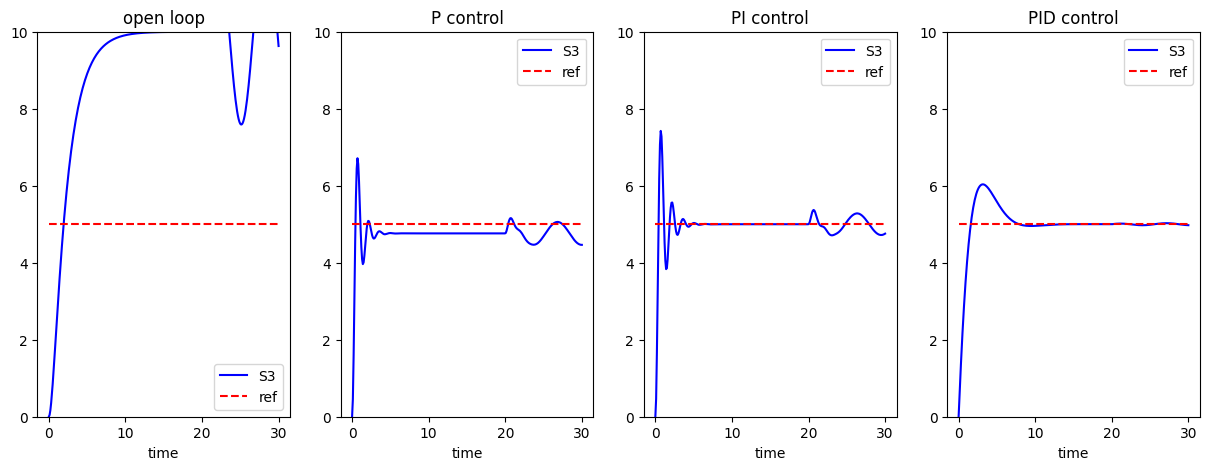

In [9]:
PIDCONTROL_MODEL = f"""
const S1;

S1 -> S2; k1*(S1 + delta*sin(time))
S2 -> S3; k2*S2
S3 -> ; k3*S3
k1 = 1
k2 = 2
k3 = 0.5
ref = 5
delta = 0
$S1 = 5
at time>20: delta = {DELTA}

// Proportional controller
kP = 100;
kI = 50
kD = 100
control_error := ref - S3
integral_error = 0
integral_error' = control_error
differential_error := -rateOf(S3)
S1 := kP*control_error + kI*integral_error + kD*differential_error
"""
plotRow([SEQUENTIAL_MODEL, PCONTROL_MODEL, PICONTROL_MODEL, PIDCONTROL_MODEL],
        ["open loop", "P control", "PI control", "PID control"])

**Observations**
* Pro
    1. Can address oscillations
* Con
    1. Very complicated to tune
    2. Oscillates and goes unstable in complicated ways

# Control Objectives

<img src="https://raw.githubusercontent.com/joseph-hellerstein/advanced-controls-lectures/main/short_class_lectures/images/control_objectives.png" 
         alt="Types of feature extractiom."
         width="600">

* Stable: bounded input produces a bounded output (BIBO)
* Final value is within tolerance
* Short settling time
* Minimal or no oscillations or overshoot/undershoot